In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pytz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
from sklearn.preprocessing import scale


from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras import regularizers # type: ignore

## Preparación de datos

### Datos con OMIP

In [3]:
df_esios_omip = pd.read_csv('data_training/predictores_modelo_futuro.csv')
df_esios_omip['Datetime_hour'] = pd.to_datetime(df_esios_omip['Datetime_hour'])

# fecha_inicio = '2025-01-01'
# df_esios_omip = df_esios_omip[df_esios_omip['Datetime_hour'] >= fecha_inicio]

utc_zone = pytz.timezone('UTC')
spain_zone = pytz.timezone('Europe/Madrid')
df_esios_omip['Datetime_hour_spain'] = df_esios_omip['Datetime_hour'].dt.tz_localize(utc_zone).dt.tz_convert(spain_zone)

df_esios_omip['Year'] = df_esios_omip['Datetime_hour_spain'].dt.year
df_esios_omip['Month'] = df_esios_omip['Datetime_hour_spain'].dt.month
df_esios_omip['Day_of_Week'] = df_esios_omip['Datetime_hour_spain'].dt.dayofweek
df_esios_omip['Hour'] = df_esios_omip['Datetime_hour_spain'].dt.hour

df_esios_omip.drop(['Datetime_hour_spain'], axis=1, inplace=True)

df_esios_omip

,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,MD_lag_48,MD_lag_1week,Hour,Month,Day_of_week,FTB,FTS,Precio_Gas,Precio_CO2_lag48,Year,Day_of_Week
0,2024-02-02 23:00:00,56.44,25367.3,6204.3,0.0,62.95,69.00,64.97,0,2,5,61.45,52.58,29.24,60.18,2024,5
1,2024-02-03 00:00:00,52.71,23677.3,5596.0,0.0,60.05,60.44,61.06,1,2,5,61.45,52.58,29.24,60.18,2024,5
2,2024-02-03 01:00:00,51.18,22408.5,5060.5,0.0,58.00,55.10,59.05,2,2,5,61.45,52.58,29.24,60.18,2024,5
3,2024-02-03 02:00:00,50.83,21695.8,4637.3,0.0,54.69,54.60,55.90,3,2,5,61.45,52.58,29.24,60.18,2024,5
4,2024-02-03 03:00:00,51.16,21351.0,4365.0,0.0,52.41,53.47,55.90,4,2,5,61.45,52.58,29.24,60.18,2024,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13027,2025-07-31 18:00:00,107.99,32459.3,9680.5,3899.3,77.99,57.58,50.00,20,7,3,35.73,8.97,32.90,72.39,2025,3
13028,2025-07-31 19:00:00,114.45,32319.0,11117.5,336.3,101.49,98.00,90.92,21,7,3,35.73,8.97,32.90,72.39,2025,3
13029,2025-07-31 20:00:00,110.27,31198.8,10593.8,0.0,104.36,103.27,90.68,22,7,3,35.73,8.97,32.90,72.39,2025,3
13030,2025-07-31 21:00:00,98.32,28856.5,10664.5,0.0,92.18,84.13,71.05,23,7,3,35.73,8.97,32.90,72.39,2025,3


In [4]:
df_input = df_esios_omip.drop(columns=['Datetime_hour'])

# Modelo Dense Neural Network

PARAMETROS

In [ ]:
porc_train = 0.5
porc_val = 0.25

n_neurons_1 = 128
n_neurons_2 = 128
dropout = 0.3

lr = 0.0005
patience = 10
batch_size = 64

### Split train - test

In [48]:
num_train_samples = int(porc_train*len(df_input))
num_val_samples = int(porc_val*len(df_input))

num_test_days = 28
num_val_days = 28

X_train = df_input.drop('MD', axis=1).iloc[:len(df_input)-num_test_days*24-num_val_days*24]
X_val = df_input.drop('MD', axis=1).iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
X_test = df_input.drop('MD', axis=1).iloc[-num_test_days*24:]

y_train = df_input['MD'].iloc[:len(df_input)-num_test_days*24-num_val_days*24]
y_val = df_input['MD'].iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
y_test = df_input['MD'].iloc[-num_test_days*24:]

Normalizacion

In [49]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Para la variable objetivo
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

### Modelo: Dense Neural Network

In [ ]:
n_features = X_train.shape[1]

# Entrada
inputs = keras.Input(shape=(n_features,))
# Primera capa interna
x = layers.Dense(n_neurons_1, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Segunda capa interna
x = layers.Dense(n_neurons_2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Salida
outputs = layers.Dense(1)(x)
# Construccion del modelo
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss='mse',
    metrics=['mae']  # MAE como métrica principal
)

c:\Users\jnavarro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_mae',  # Monitorear MAE de validation
        patience=patience,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'modelo_futuro.keras',
        monitor='val_mae',
        save_best_only=True,
        verbose=1
    )
]
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),  # Usar validation set
    epochs=150,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
159/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4996 - mae: 0.9211
Epoch 1: val_mae improved from None to 0.65939, saving model to modelo_futuro.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9389 - mae: 0.7307 - val_loss: 0.5556 - val_mae: 0.6594
Epoch 2/150
169/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4312 - mae: 0.4978
Epoch 2: val_mae improved from 0.65939 to 0.32468, saving model to modelo_futuro.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3667 - mae: 0.4561 - val_loss: 0.2010 - val_mae: 0.3247
Epoch 3/150
164/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2539 - mae: 0.3718
Epoch 3: val_mae improved from 0.32468 to 0.30066, saving model to modelo_futuro.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2299 - mae: 0.3495 - val_loss: 0.1772 - val_mae: 0.3007
Epoch 4/150
168/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1880 - mae: 0.3095
Epoch 4: val_mae improved from 0.30066 to 0.27464, saving model to modelo_futuro.keras
183/18

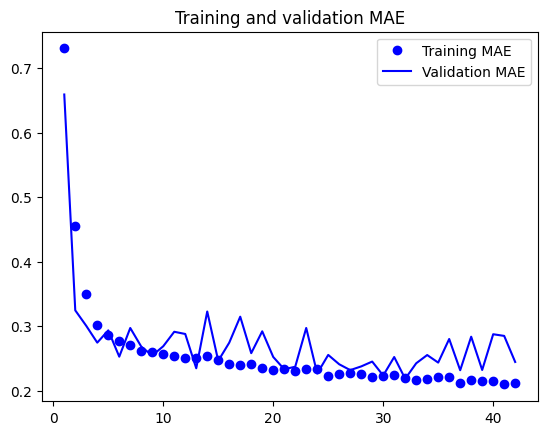

In [52]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [55]:
# Evaluar el modelo con el test set (datos nunca vistos)
print("\n" + "="*50)
print("EVALUACIÓN FINAL CON TEST SET")
print("="*50)

# Hacer predicciones en el test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# MAE
mae_test = mean_absolute_error(y_real, y_pred)
print(f"MAE en Test Set: {mae_test:.2f} €/MWh")
print(f"Error absoluto medio: ±{mae_test:.2f} €/MWh")


fechas_test = df_esios_omip['Datetime_hour'].iloc[-num_test_days*24:]

# Crear un DataFrame con los datos para Plotly
df_plot = pd.DataFrame({
    'Fecha': fechas_test,
    'Valor Real': y_real,
    'Predicción': y_pred
})

# Crear el gráfico interactivo con Plotly Express
fig = px.line(df_plot, x='Fecha', y=['Valor Real', 'Predicción'],
              title='Predicciones vs Valores Reales (Test Set)',
              labels={'value': 'Precio (Escala Original)', 'variable': 'Leyenda'},
              color_discrete_map={'Valor Real': 'blue', 'Predicción': 'orange'})

# Personalizar el gráfico
fig.update_layout(
    title_font_size=16,
    xaxis_title='Fecha',
    xaxis_title_font_size=14,
    yaxis_title='Precio (Escala Original)',
    yaxis_title_font_size=14,
    legend_title='',
    width=1000,
    height=500,
    template='plotly_white'
)

# Ajustar la opacidad de la línea de predicción
fig.update_traces(opacity=0.7, selector={'name': 'Predicción'})

# Mostrar la cuadrícula
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Mostrar el gráfico
fig.show()


EVALUACIÓN FINAL CON TEST SET
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE en Test Set: 17.60 €/MWh
Error absoluto medio: ±17.60 €/MWh


# Evaluacion final